### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 5
### Due: Friday, Mar 27th at 11.59pm CST
---

## Only one problem this week

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw5_data_1.npy`. This is a (10 x 3) numpy array, containing some time-series measurements. It could be flux measurements from a star or some other transient. The first column is time (arbitrary units), the second column is the flux (arbitrary units), and the third column are homoescedastic measurement uncertainties on the flux. Plot this data with the uncertainties.

2) One possible model for this data is a sharp burst with an exponential tail rising above a nominal background level. This model can be described as:

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

where $b$ is the background amplitude, $A$ is the burst amplitude, $t_0$ is the burst epoch, and $\alpha$ encodes how rapidly the burst dies off.

Code this burst model, and code a likelihood function for this data with the burst model. *Hint: This is similar in spirit to the likelihood when fitting polynomials to data, except now $x$ is time, and the polynomial model is now the burst model.* 

3) Using one of the MCMC codes that we looked at in class (`emcee`, `pymc3`, `PTMCMCSampler`) perform a Bayesian analysis that recovers an MCMC chain of posterior probability samples for the joint parameter space of $\{b,A,t_0,\alpha\}$. You must decide on how many samples are appropriate for running your MCMC. For your priors, make them $b\in \mathrm{Uniform}[0,50]$, $A\in \mathrm{Uniform}[0,50]$, $t_0\in \mathrm{Uniform}[0,100]$, and $\ln\alpha\in \mathrm{Uniform}[-5,5]$.

4) Perform an appropriate check to burn-in your chain, and thin the chain by selecting only points every auto-correlation length. If you are left with a small number of samples after thinning then you may need to run your MCMC for longer in (3).

5) Make a corner plot of the $4$-D parameter space, with labels, $[68,95]\%$ credible levels and quantiles, and titles.

6) Now choose $100$ samples randomly from your burned, thinned chain and plot the $100$ corresponding burst time-series on a figure along with the original data. You may want to choose a transparency for these $100$ burst curves that allows you to see everything nicely. These are showing the posterior spread of model solutions that are consistent with the data.

7) Another possible model that may explain the data is a Gaussian profile described by:

$y = b + A\exp[-(t-t_0)^2 / 2\sigma_W^2]$

The priors for this model are the same as above for the equivalent parameters, and with $\ln\sigma_W\in\mathrm{Uniform}[-2,2]$. Following the examples from `Lecture 12` and from relevant web tutorials/documentation, use one of the nested sampling packages (`dynesty` or `UltraNest`) to compute the Bayesian evidence for this Gaussian model, and for the original burst model. Compute the Bayes factor, and state which model is the favored description of the data. *Hint: Be careful with how you transform your parameter space into a unit hypercube for the nested sampling priors. An appropriate check on whether you have done things correctly is that the posterior samples you get from the burst analysis here should give an equivalent corner plot to the MCMC you did above.*

### Solution

In [1]:
import numpy as np
import matplotlib.pyplot as plt

##### 1.

In [2]:
# load the data
data = np.load('../../homeworks/hw_data/hw5_data_1.npy')

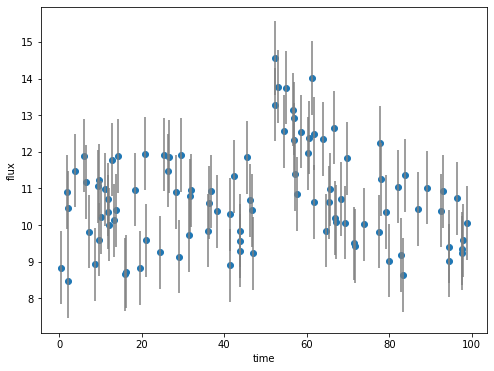

In [4]:
# plot the data with errors
plt.figure(figsize=(8,6))
plt.errorbar(data[:,0], data[:,1], yerr=data[:,2], ls='', ecolor='grey')
plt.scatter(data[:,0], data[:,1])
plt.xlabel('time')
plt.ylabel('flux');

##### 2

In [5]:
def burst(t, params):
    """
        a function to calculate the burst model for
        given times t and other parameters
    """
    
    A, b, t0, alpha = params
    
    dist = np.zeros(len(t))
    dist[t < t0] = b
    dist[t >= t0] = b + A*np.exp(-alpha*(t[t >= t0]-t0))
    
    return dist

In [6]:
import scipy
from scipy.stats import norm

def lnlikely(params, data=data, model=burst):
    """
        a function to calculate the log
        likelihood of a chosen model
    """
    t = data[:,0]
    y = data[:,1]
    #sigma_y = data[:,2]
    sigma_y = 1  # homoskedastic, so let's make it quicker
    
    y_fit = model(t, params)
    return sum(norm.logpdf(y, y_fit, sigma_y))

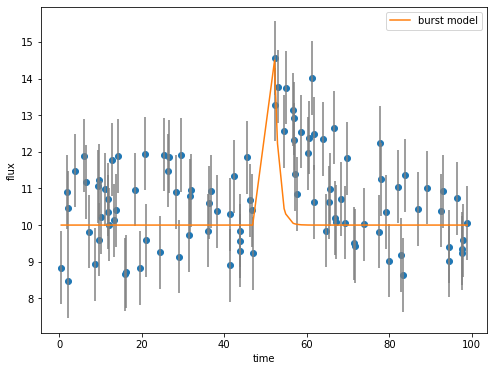

In [19]:
# plot the data with errors
plt.figure(figsize=(8,6))
plt.errorbar(data[:,0], data[:,1], yerr=data[:,2], ls='', ecolor='grey')
plt.scatter(data[:,0], data[:,1])
plt.plot(data[:,0], burst(data[:,0], np.array([40., 10., 50., 1])), label='burst model')
plt.legend()
plt.xlabel('time')
plt.ylabel('flux');

##### 3.

In [20]:
from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc

Do not have mpi4py package.


In [22]:
from scipy.stats import uniform
def lnprior_burst(params):
    """
        function to calculate the log prior
        for given parameters
    """
    
    A, b, t0, alpha = params
    
    """
    ### I experimented with this section but it was slower
    ### than my other solution below
    ### they both give the same results
    
    logpdf = uniform.logpdf(A, 0, 50) + uniform.logpdf(b, 0, 50) +\
          uniform.logpdf(t0, 0, 100) + uniform.logpdf(np.log(alpha), -5, 10)
          
    return logpdf
    """
    
    if (0 <= A <= 50) and (0 <= b <= 50) and\
       (0 <= t0 <= 100) and (-5 <= np.log(alpha) <= 5):
        return np.log(1/50*1/50*0.01*0.1)
    else:
        return -np.inf

In [23]:
# setup sampler
ndim = 4
cov = np.diag(np.ones(ndim) * 0.01**2)
sampler = ptmcmc(ndim, lnlikely, lnprior_burst, cov, outDir = 'burst', loglkwargs={'model':burst})

In [ ]:
# run sampler with initial parameters
N = 400000
p0 = np.array([10., 10., 50., 1.])
sampler.sample(p0, N)

##### 4.

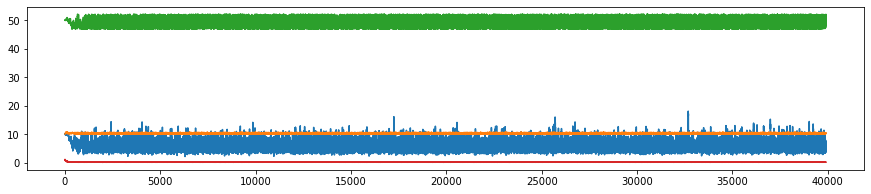

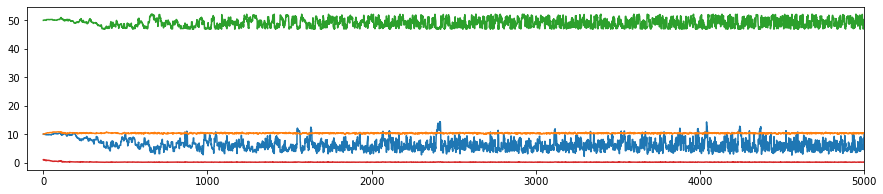

In [24]:
# load posterior chain and plot
chain = np.loadtxt('burst/chain_1.txt')

plt.figure(figsize=(15,3))
plt.plot(chain[:,:4]);

plt.figure(figsize=(15,3))
plt.plot(chain[:,:4])
plt.xlim(-100,5000);

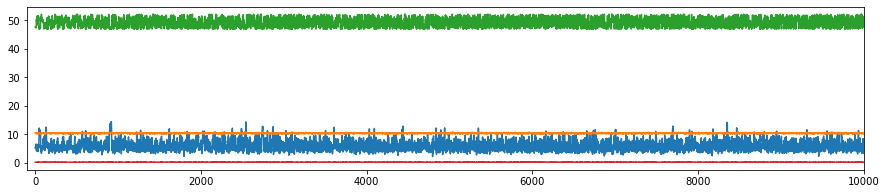

In [33]:
# appears that burn-in ends after some 1500 samples
burn = 1500

# let's check this!
plt.figure(figsize=(15,3))
plt.plot(chain[:,:4][burn:])
plt.xlim(-100,10000);

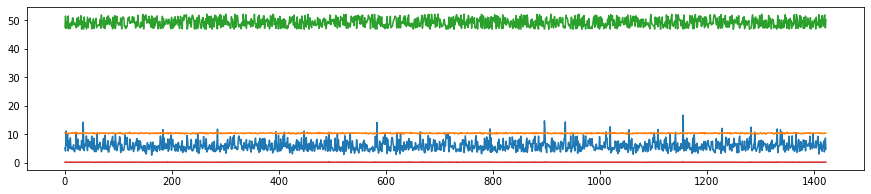

In [35]:
# calculate autocorrelation length
import acor
thin = int(acor.acor(chain[:,0])[0])
plt.figure(figsize=(15,3))
plt.plot(chain[:,:4][burn::thin]);

In [36]:
print(f'Autocorrelation length: {thin}')

Autocorrelation length: 27


##### 5.

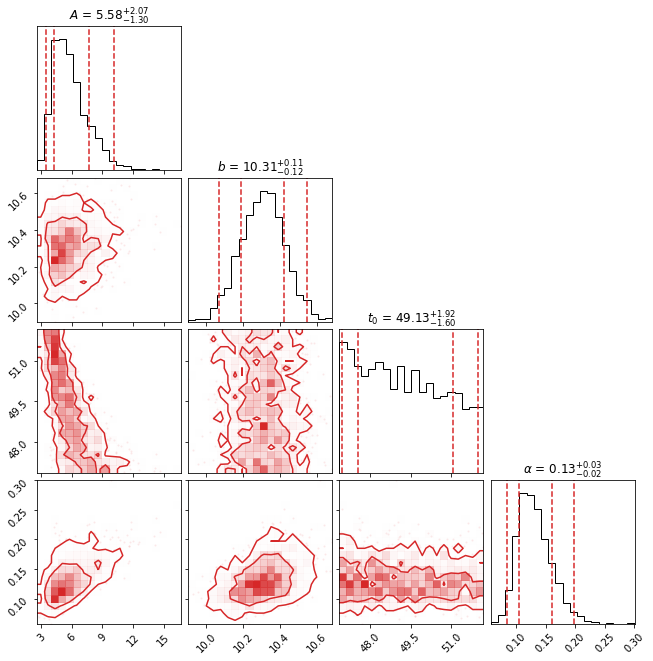

In [48]:
# plot corner plot
import corner
labels = [r'$A$', r'$b$', r'$t_0$', r'$\alpha$']
corner.corner(chain[:,:4][burn::thin], titles=labels, show_titles=True,
              levels=[.68,.95], quantiles=(0.16, 0.84, .025, .975),
              color='C3', hist_kwargs={'color':'k'});

###### 6.

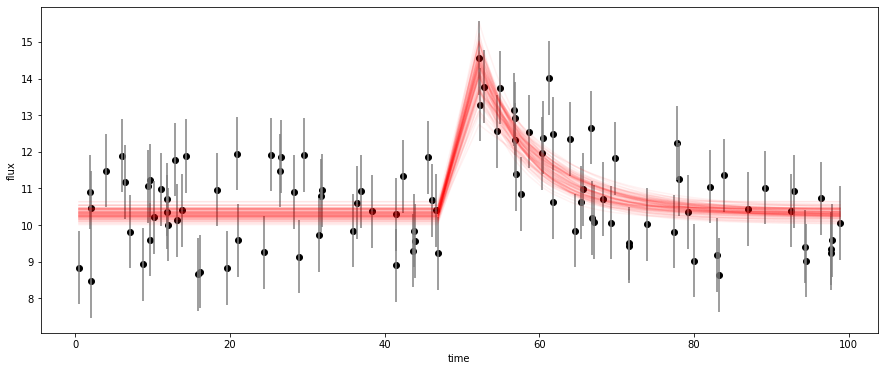

In [51]:
# randomly choose 100 samples from chain
from numpy.random import choice
idx = choice(chain[:,0][burn::thin].shape[0], 100, replace=False)
X_random = chain[:,:4][burn::thin][idx]

# overplot on data
plt.figure(figsize=(15,6))

t = data[:,0]
[plt.plot(t, burst(t, X), alpha=0.05, c='r') for X in X_random]

plt.errorbar(data[:,0], data[:,1], yerr=data[:,2], ls='', ecolor='gray')
plt.scatter(data[:,0], data[:,1], c='k')

plt.xlabel('time')
plt.ylabel('flux');

##### 7.

In [52]:
# parameter labels for each model
param_burst = ['A', 'b', 't0', 'alpha']
param_gauss = ['A', 'b', 't0', 'sigmaW']

In [53]:
def prior_transform_burst(params):
    """
        transform unit hypercube to
        prior distributions for burst model
    """
    
    # params = {A, b, t0, alpha}
    proposed = params.copy()
    
    # prior on A - uniform in [0,50]
    lo, hi = 0, 50
    proposed[0] = params[0] * (hi - lo) + lo
    
    # prior on b - uniform in [0, 50]
    lo, hi = 0, 50
    proposed[1] = params[1] * (hi - lo) + lo
    
    # prior on t0 - uniform in [0, 100]
    lo, hi = 0, 100
    proposed[2] = params[2] * (hi - lo) + lo
    
    # prior on alpha - log uniform in [-5, 5]
    lo, hi = -5, 5
    proposed[3] = np.exp((params[3] * (hi - lo) + lo))
    
    return proposed

In [54]:
def prior_transform_gauss(params):
    """
        transform unit hypercube to
        prior distributions for burst model
    """
    
    # params = {A, b, t0, sigmaW}
    proposed = params.copy()
    
    # prior on A - uniform in [0,50]
    lo, hi = 0, 50
    proposed[0] = params[0] * (hi - lo) + lo
    
    # prior on b - uniform in [0, 50]
    lo, hi = 0, 50
    proposed[1] = params[1] * (hi - lo) + lo
    
    # prior on t0 - uniform in [0, 100]
    lo, hi = 0, 100
    proposed[2] = params[2] * (hi - lo) + lo
    
    # prior on sigmaW - log uniform in [-2, 2]
    lo, hi = -2, 2
    proposed[3] = np.exp((params[3] * (hi - lo) + lo))
    
    return proposed

In [55]:
def gauss(t, params):
    """
        a function to calculate the guassian 
        model for given times t and other parameters
    """
    
    A, b, t0, sigmaW = params
    
    return b + A*np.exp(-(t-t0)**2/(2*sigmaW**2))

In [56]:
import ultranest

In [57]:
# run sampler for burst - lnlikely model kwarg default 'burst'
sampler = ultranest.ReactiveNestedSampler(param_burst, lnlikely, prior_transform_burst,
                                log_dir='ultranest/burst/', resume='overwrite')

In [58]:
# run the sampler
burst = sampler.run(show_status=False)
sampler.print_results()

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+02  
[ultranest] Likelihood function evaluations: 80434
[ultranest] Writing samples and results to disk ...
[ultranest] Writing samples and results to disk ... done
[ultranest]   logZ = -155.1 +- 0.1481
[ultranest] Effective samples strategy satisfied (ESS = 1868.5, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.54, need <0.5)
[ultranest]   logZ error budget: single: 0.18 bs:0.15 tail:0.01 total:0.15 required:<0.50
[ultranest] done iterating.

logZ = -155.074 +- 0.311
  single instance: logZ = -155.074 +- 0.180
  bootstrapped   : logZ = -155.120 +- 0.311
  tail           : logZ = +- 0.010
insert order U test : converged: False correlation: 73.0 iterations

    A                   5.7 +- 1.6
    b                   10.29 +- 0.12
    t0                  49.2 +- 1.5
    alpha               0.125 +- 0.027


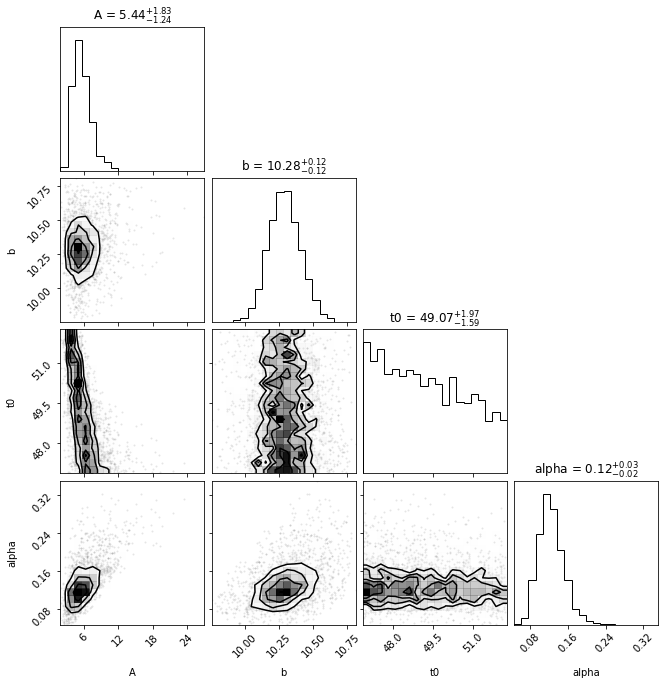

In [64]:
# corner plot
from ultranest.plot import cornerplot
fig = cornerplot(burst)
#corner.corner(chain[:,:4][burn::thin], fig=fig, color='C0', titles=labels,
#              show_titles=True);

In [65]:
# modifying lnlikely function to change default model to 'gauss'
# I don't think ultranest has a loglkwargs option...
# ...that's annoying
def lnlikely(params, data=data, model=gauss):  #model dafault changed here!
    """
        a function to calculate the log
        likelihood of a chosen model
    """
    t = data[:,0]
    y = data[:,1]
    #sigma_y = data[:,2]
    sigma_y = 1  # homoskedastic, so let's make it quicker
    
    y_fit = model(t, params)
    return sum(norm.logpdf(y, y_fit, sigma_y))

In [66]:
# run sampler for burst
sampler = ultranest.ReactiveNestedSampler(param_gauss, lnlikely, prior_transform_gauss,
                                log_dir='ultranest/gauss/', resume='overwrite')
# run the sampler
gauss = sampler.run(show_status=False)
sampler.print_results()

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+02  
[ultranest] Likelihood function evaluations: 60165
[ultranest] Writing samples and results to disk ...
[ultranest] Writing samples and results to disk ... done
[ultranest]   logZ = -159.9 +- 0.1391
[ultranest] Effective samples strategy satisfied (ESS = 2212.6, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.30, need <0.5)
[ultranest]   logZ error budget: single: 0.18 bs:0.14 tail:0.01 total:0.14 required:<0.50
[ultranest] done iterating.

logZ = -159.886 +- 0.274
  single instance: logZ = -159.886 +- 0.184
  bootstrapped   : logZ = -159.901 +- 0.274
  tail           : logZ = +- 0.010
insert order U test : converged: False correlation: 6497.0 iterations

    A                   2.77 +- 0.39
    b                   10.32 +- 0.12
    t0                  55.4 +- 1.0
    sigmaW              5.24 +- 0.85


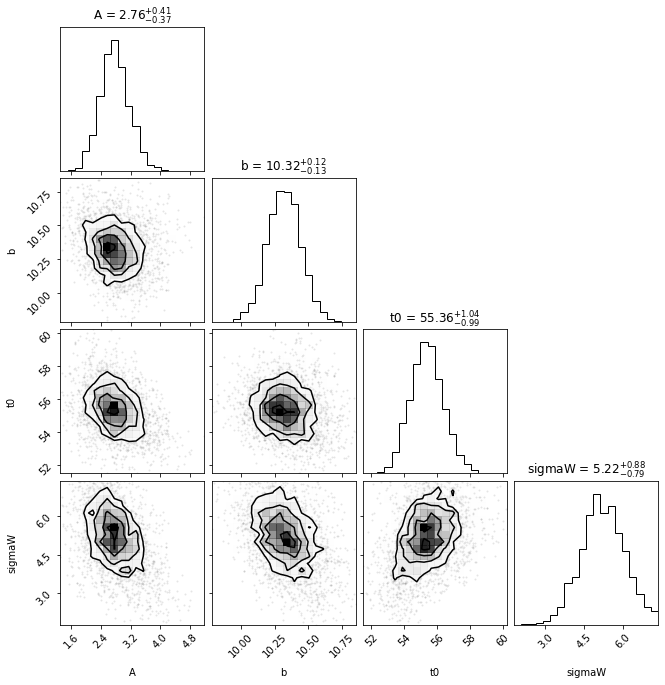

In [67]:
# corner plot gauss model
cornerplot(gauss)

In [73]:
bayes_factor = np.exp(burst['logz'] - gauss['logz'])
print(f'Bayes factor burst:gauss = {bayes_factor:.3f}')
print('The data significantly favours the burst model over the gauss model')

Bayes factor burst:gauss = 123.003
The data significantly favours the burst model over the gauss model
